In [29]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [50]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [31]:
def model(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [32]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [33]:
w1 = torch.ones(())
w2 = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w1, w2, b)
t_p


tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [34]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [35]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [36]:
delta = 0.1

loss_rate_of_change_w2 = (loss_fn(model(t_u, w2 + delta, w1, b), t_c) - loss_fn(model(t_u, w2 - delta, w1, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w1 = (loss_fn(model(t_u, w2, w1 + delta, b), t_c) - loss_fn(model(t_u, w2, w1 - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_b = (loss_fn(model(t_u, w2, w1, b + delta), t_c) - loss_fn(model(t_u, w2, w1, b - delta), t_c)) / (2.0 * delta)

In [37]:
learning_rate = 1e-2

w2 = w2 - learning_rate * loss_rate_of_change_w2
w1 = w1 - learning_rate * loss_rate_of_change_w1
b = b - learning_rate * loss_rate_of_change_b

In [38]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w2, w1, b + delta), t_c) -
     loss_fn(model(t_u, w2, w1, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [39]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [40]:
def dmodel_dw2(t_u, w2, w1, b):
    return t_u ** 2

def dmodel_dw1(t_u, w2, w1, b):
    return t_u

In [41]:
def dmodel_db(t_u, w2, w1, b):
    return 1.0

In [42]:
def grad_fn(t_u, t_c, t_p, w2, w1, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w2, w1, b)  # New derivative for w2
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w2, w1, b)  # New derivative for w1
    dloss_db = dloss_dtp * dmodel_db(t_u, w2, w1, b)
    return torch.stack([dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])

In [43]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w2, w1, b = params  # Unpack parameters

        t_p = model(t_u, w2, w1, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w2, w1, b)  # <2>

        torch.nn.utils.clip_grad_norm_(params, max_norm=1)

        params = params - learning_rate * grad



        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>

    return params

In [68]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w2, w1, b = params  # Unpack parameters

        t_p = model(t_u, w2, w1, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w2, w1, b)  # <2>

        torch.nn.utils.clip_grad_norm_(params, max_norm=1)

        params = params - learning_rate * grad
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [69]:
# Normalize t_u
t_u_mean = t_u.mean()
t_u_std = t_u.std()
t_u_normalized = (t_u - t_u_mean) / t_u_std

# Call training_loop with normalized data
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([0.0, 0.1, 0.0]),  # Optional: Re-initialize params
    t_u = t_u_normalized,
    t_c = t_c
)

Epoch 1, Loss 185.752762
    Params: tensor([0.1979, 0.2625, 0.2100])
    Grad:   tensor([-19.7921, -16.2453, -21.0000])
Epoch 2, Loss 175.008652
    Params: tensor([0.3838, 0.4223, 0.4122])
    Grad:   tensor([-18.5906, -15.9806, -20.2201])
Epoch 3, Loss 165.111832
    Params: tensor([0.5584, 0.5794, 0.6070])
    Grad:   tensor([-17.4541, -15.7189, -19.4777])
...
Epoch 10, Loss 113.846382
    Params: tensor([1.5098, 1.6091, 1.7902])
    Grad:   tensor([-11.0521, -13.9727, -15.1791])
Epoch 11, Loss 108.463455
    Params: tensor([1.6130, 1.7464, 1.9369])
    Grad:   tensor([-10.3259, -13.7358, -14.6746])
...
Epoch 99, Loss 8.299847
    Params: tensor([2.1266, 7.7509, 7.2211])
    Grad:   tensor([ 1.2363, -2.7158, -2.7233])
Epoch 100, Loss 8.137818
    Params: tensor([2.1143, 7.7775, 7.2480])
    Grad:   tensor([ 1.2288, -2.6645, -2.6914])


tensor([2.1143, 7.7775, 7.2480])

In [70]:
# Normalize t_u
t_u_mean = t_u.mean()
t_u_std = t_u.std()
t_u_normalized = (t_u - t_u_mean) / t_u_std

# Call training_loop with normalized data
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([0.0, 0.1, 0.0]),  # Optional: Re-initialize params
    t_u = t_u_normalized,
    t_c = t_c
)

Epoch 1, Loss 185.752762
    Params: tensor([0.1979, 0.2625, 0.2100])
    Grad:   tensor([-19.7921, -16.2453, -21.0000])
Epoch 2, Loss 175.008652
    Params: tensor([0.3838, 0.4223, 0.4122])
    Grad:   tensor([-18.5906, -15.9806, -20.2201])
Epoch 3, Loss 165.111832
    Params: tensor([0.5584, 0.5794, 0.6070])
    Grad:   tensor([-17.4541, -15.7189, -19.4777])
...
Epoch 10, Loss 113.846382
    Params: tensor([1.5098, 1.6091, 1.7902])
    Grad:   tensor([-11.0521, -13.9727, -15.1791])
Epoch 11, Loss 108.463455
    Params: tensor([1.6130, 1.7464, 1.9369])
    Grad:   tensor([-10.3259, -13.7358, -14.6746])
...
Epoch 99, Loss 8.299847
    Params: tensor([2.1266, 7.7509, 7.2211])
    Grad:   tensor([ 1.2363, -2.7158, -2.7233])
Epoch 100, Loss 8.137818
    Params: tensor([2.1143, 7.7775, 7.2480])
    Grad:   tensor([ 1.2288, -2.6645, -2.6914])


tensor([2.1143, 7.7775, 7.2480])

In [71]:
t_un = 0.1 * t_u

In [72]:
# Normalize t_u
t_u_mean = t_u.mean()
t_u_std = t_u.std()
t_u_normalized = (t_u - t_u_mean) / t_u_std

# Call training_loop with normalized data
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([0.0, 0.1, 0.0]),  # Optional: Re-initialize params
    t_u = t_u_normalized,
    t_c = t_c
)

Epoch 1, Loss 185.752762
    Params: tensor([0.1979, 0.2625, 0.2100])
    Grad:   tensor([-19.7921, -16.2453, -21.0000])
Epoch 2, Loss 175.008652
    Params: tensor([0.3838, 0.4223, 0.4122])
    Grad:   tensor([-18.5906, -15.9806, -20.2201])
Epoch 3, Loss 165.111832
    Params: tensor([0.5584, 0.5794, 0.6070])
    Grad:   tensor([-17.4541, -15.7189, -19.4777])
...
Epoch 10, Loss 113.846382
    Params: tensor([1.5098, 1.6091, 1.7902])
    Grad:   tensor([-11.0521, -13.9727, -15.1791])
Epoch 11, Loss 108.463455
    Params: tensor([1.6130, 1.7464, 1.9369])
    Grad:   tensor([-10.3259, -13.7358, -14.6746])
...
Epoch 99, Loss 8.299847
    Params: tensor([2.1266, 7.7509, 7.2211])
    Grad:   tensor([ 1.2363, -2.7158, -2.7233])
Epoch 100, Loss 8.137818
    Params: tensor([2.1143, 7.7775, 7.2480])
    Grad:   tensor([ 1.2288, -2.6645, -2.6914])


tensor([2.1143, 7.7775, 7.2480])

In [79]:
# Normalize t_un
t_un_mean = t_un.mean()
t_un_std = t_un.std()
t_un_normalized = (t_un - t_un_mean) / t_un_std

# Call training_loop with normalized data
params = training_loop(
    n_epochs=5000,
    learning_rate=.001,
    params=torch.tensor([0.0, 1.0, 0.0]),  # Initial values for w2, w1, b
    t_u=t_un_normalized,  # Pass normalized data here
    t_c=t_c,
    print_params=False
)

params

Epoch 1, Loss 171.868347
Epoch 2, Loss 170.818832
Epoch 3, Loss 169.778091
...
Epoch 10, Loss 162.730972
Epoch 11, Loss 161.757263
...
Epoch 99, Loss 100.352562
Epoch 100, Loss 99.863228
...
Epoch 500, Loss 24.461193
Epoch 1000, Loss 7.775002
Epoch 1500, Loss 3.801597
Epoch 2000, Loss 2.663065
Epoch 2500, Loss 2.293672
Epoch 3000, Loss 2.164762
Epoch 3500, Loss 2.118086
Epoch 4000, Loss 2.100893
Epoch 4000, Loss 2.100893
Epoch 4500, Loss 2.094512
Epoch 5000, Loss 2.092136
Epoch 5000, Loss 2.092136


tensor([0.8279, 9.1073, 9.7244])

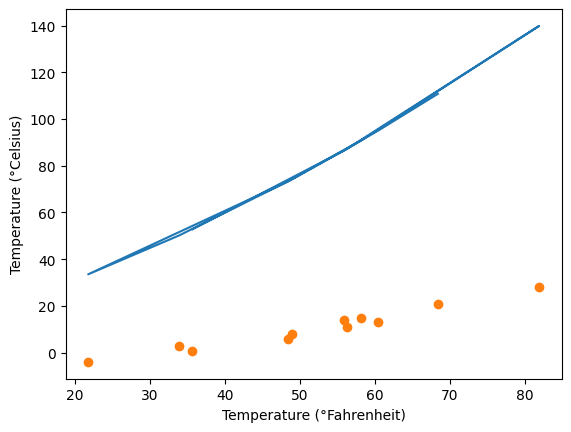

In [63]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

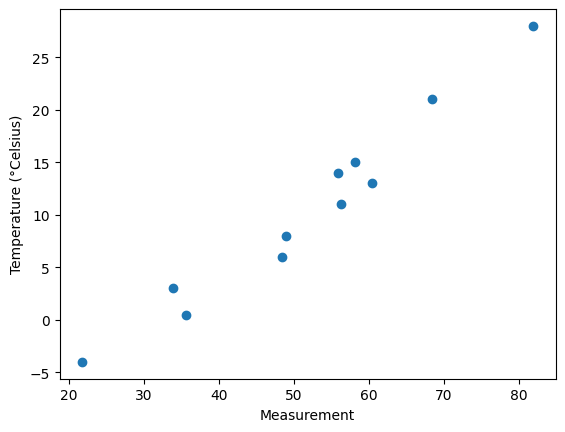

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=100)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

In [101]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'

data = pd.DataFrame(pd.read_csv(url))

data.isnull().sum()*100/data.shape[0]

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
data[varlist] = data[varlist].apply(binary_map)
data.head()

from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.8, test_size = 0.2, random_state = 100)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

y_train = df_train.pop('price')
X_train = df_train

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Check and convert all columns to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train = X_train.fillna(0)  # Replace missing values with 0 or another strategy

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)  # One output for regression

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_features = X_train.shape[1]
model = LinearRegressionModel(input_features)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5001
for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_split)
    loss = criterion(predictions, y_train_split)
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_split)
        val_loss = criterion(val_predictions, y_val_split)

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Final model parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Training Loss: 0.1880, Validation Loss: 0.1371
Epoch 500, Training Loss: 0.0150, Validation Loss: 0.0149
Epoch 1000, Training Loss: 0.0094, Validation Loss: 0.0105
Epoch 1500, Training Loss: 0.0084, Validation Loss: 0.0102
Epoch 2000, Training Loss: 0.0083, Validation Loss: 0.0103
Epoch 2500, Training Loss: 0.0083, Validation Loss: 0.0103
Epoch 3000, Training Loss: 0.0083, Validation Loss: 0.0103
Epoch 3500, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 4000, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 4500, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 5000, Training Loss: 0.0083, Validation Loss: 0.0104
linear.weight: tensor([[ 0.3161,  0.0573,  0.3084,  0.1125,  0.0482,  0.0357,  0.0242,
          0.0702,  0.0655,  0.0883,  0.0533, -0.2349]])
linear.bias: tensor([-0.0040])


In [102]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'

data = pd.DataFrame(pd.read_csv(url))

data.isnull().sum()*100/data.shape[0]

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
data[varlist] = data[varlist].apply(binary_map)
data.head()

from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.8, test_size = 0.2, random_state = 100)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'price']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

y_train = df_train.pop('price')
X_train = df_train

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Check and convert all columns to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train = X_train.fillna(0)  # Replace missing values with 0 or another strategy

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)  # One output for regression

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_features = X_train.shape[1]
model = LinearRegressionModel(input_features)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5001
for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_split)
    loss = criterion(predictions, y_train_split)
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_split)
        val_loss = criterion(val_predictions, y_val_split)

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Final model parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Training Loss: 0.2075, Validation Loss: 0.2229
Epoch 500, Training Loss: 0.0168, Validation Loss: 0.0169
Epoch 1000, Training Loss: 0.0107, Validation Loss: 0.0116
Epoch 1500, Training Loss: 0.0090, Validation Loss: 0.0107
Epoch 2000, Training Loss: 0.0084, Validation Loss: 0.0104
Epoch 2500, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 3000, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 3500, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 4000, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 4500, Training Loss: 0.0083, Validation Loss: 0.0104
Epoch 5000, Training Loss: 0.0083, Validation Loss: 0.0104
linear.weight: tensor([[0.3161, 0.0574, 0.3084, 0.1125, 0.0482, 0.0357, 0.0242, 0.0702,
         0.0655, 0.0883, 0.0533, 0.2175]])
linear.bias: tensor([-0.0041])
